# Credit Card Fraud Detection System

This notebook contains my approach towards credit card fraud detection using Machine Learning Algorithms. Credit card fraud detection is a very serious modern day problem. In this notebook my aim will be to get the maximum possible accuracy for the European Tracsaction data set which was released in 2013. The metrics I will be using is F1- Score, Precision and Recall.

We will first import the necessary libraries for EDA:

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import warnings
import time
warnings.filterwarnings("ignore")

from sklearn.inspection import permutation_importance
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.preprocessing import PowerTransformer, QuantileTransformer

from sklearn import metrics
from sklearn.metrics import auc, f1_score, plot_roc_curve, precision_score, recall_score

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

Now let us import the data we have:

In [11]:
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


**Now let us check if there are any null values present in our data set:**

If null values are found we will replace these values with the mean or median of that data attribute.

In [12]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

As we can see there are no null values in our data set so we can move forward and understand our dataset.

In [13]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,1.673327e-15,-1.247012e-15,8.190001e-16,1.207294e-15,4.887456e-15,1.437716e-15,-3.772171e-16,9.564149e-16,1.039917e-15,6.406204e-16,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


### EDA (Exploratory Data Analysis):
In this step we will plot different graphs and try to find out different patterns in our data which will help us for feature selection.

#### Distribution of Target Variable:
The graph below shows the distribution of our target varible which has two values 0 and 1 indicating not a fraud and a fraud respectively.

[]

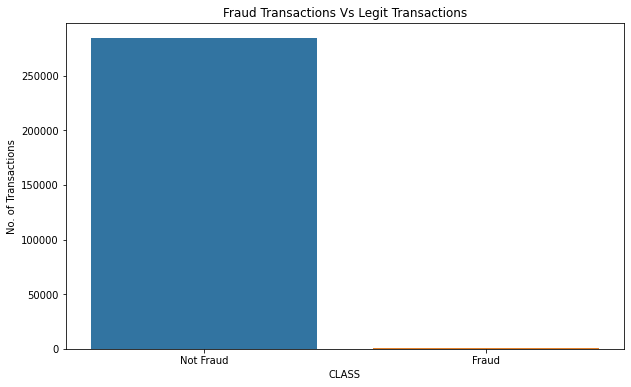

In [14]:
data = list(df["Class"].values)
ones = data.count(1)
zeros = data.count(0)
fig = plt.figure(figsize=(10,6))
sns.barplot(x=["Not Fraud", "Fraud"], y = [zeros, ones])
plt.title("Fraud Transactions Vs Legit Transactions")
plt.xlabel("CLASS")
plt.ylabel("No. of Transactions")
plt.plot()

It is clearly visible that there is a great imbalance in the data where we have extremely low fraud transactions and too many legit ones so to tackle this issue we will have to use techniques like undersapling the data while traning our model.

### Fixing Data Set Imbalance:
Now the next step will be data preparation for model fitting and testing. In our data as discussed above there is a lot of imbalance in the the Legit and the Fraud Transactions so we will do some oversampling or undersampling of data. As our Data set is not very huge we will use oversampling which will prevent the loss of any kind of valuable data. We will keep the fraud transactions and the legit ones in ratio of about 1:1 which will make it perfectly balanced. 

To do so we will take help of the imblearn library in python.

In [15]:
over_sampler = RandomOverSampler(sampling_strategy="minority")
X = df.iloc[:, :30]
Y = df.iloc[:, 30]

X_oversampled, Y_oversampled = over_sampler.fit_resample(X, Y)
counter = 0
o_df = pd.DataFrame()
for i in list(df.columns)[:30]:
    o_df[i] = X_oversampled[i]
    counter += 1
    
o_df["Class"] = Y_oversampled
df = o_df.copy()
Counter(Y_oversampled)

Counter({0: 284315, 1: 284315})

**Now let us check for the data distribution for the other attributes as well:**

We want the distribution tu be Gaussian if not then we will apply data transformation tecniques to convert it into a Gaussian curve.

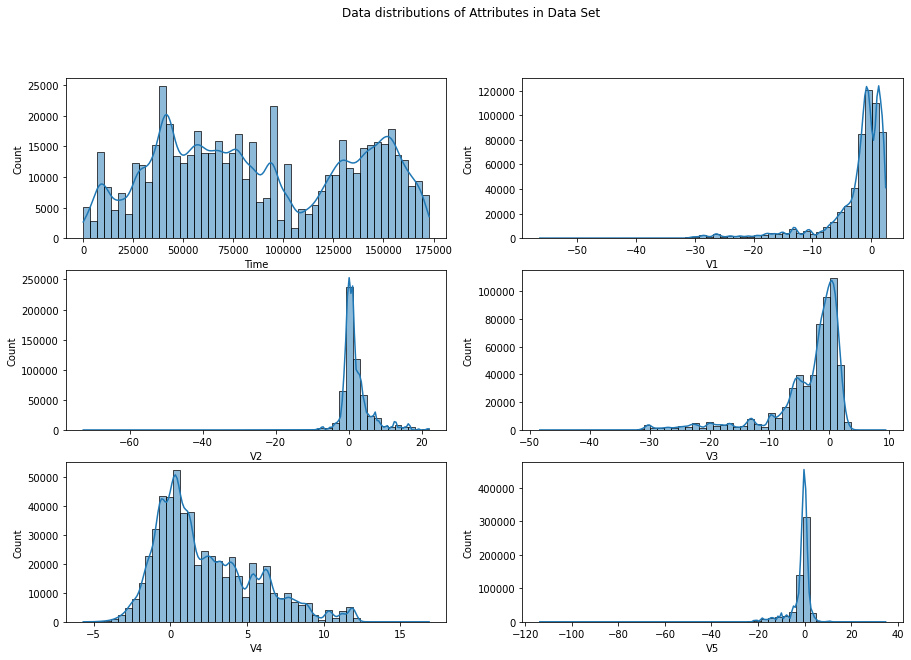

In [16]:
columns = list(df.columns)

def data_distribution(columns, bins = 50):
    fig = plt.figure(figsize=(15, 10))
    plt.suptitle("Data distributions of Attributes in Data Set")
    counter = 1
    for i in columns:
        plt.subplot(3,2, counter)
        sns.histplot(df[i], bins = bins, kde = True)
        counter += 1
        
data_distribution(columns[:6])

**In the graphs above it is visible that the distribution of Time, V1, V3, V4 is not gaussian so we will have to do transformation of these columns**
1. Time = Not Smooth Gaussian
2. V1 = Not Smooth Gaussian
3. V3 = Left Skewed
4. V4 = Right Skewed

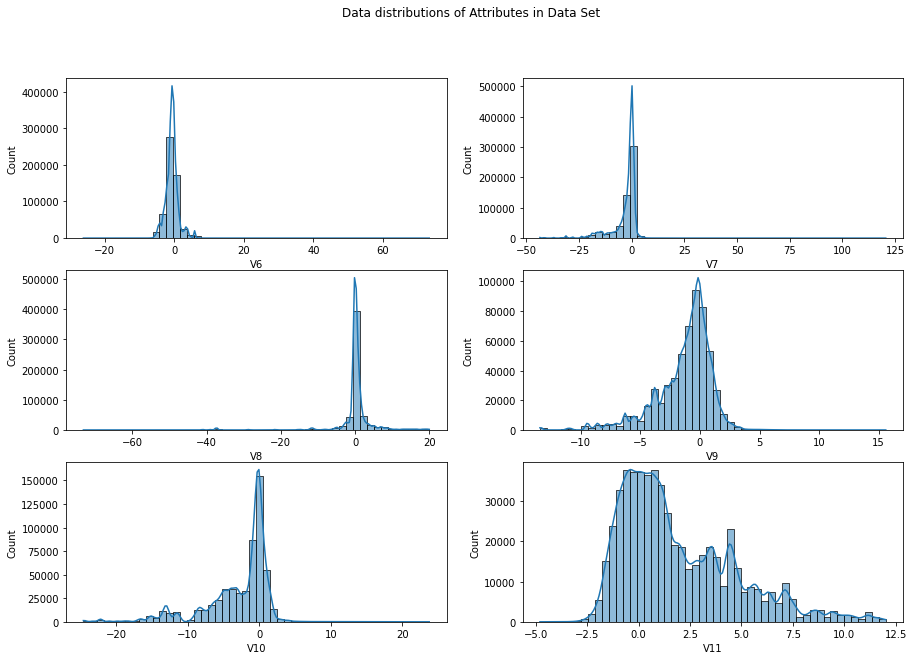

In [17]:
data_distribution(columns[6:12])

**Some of the graphs above show normal Gaussian Distribution which means no transformation is required for those but V7, V10, V11 need transformation**
1. V7 = Left Skewed
2. V10 = Left Skewed
3. V11 = Right Skewed

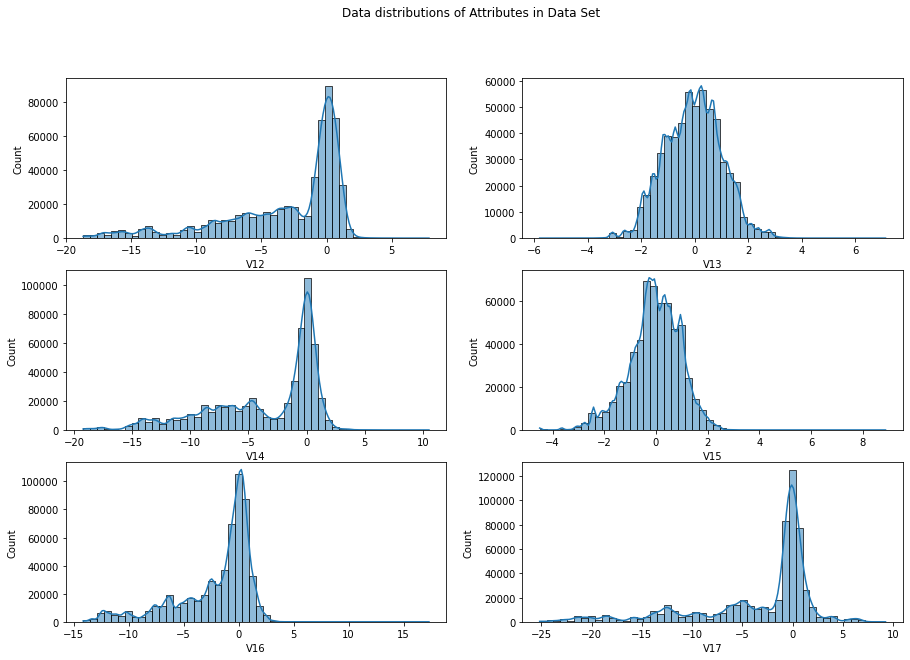

In [18]:
data_distribution(columns[12:18])

**Most of the graphs above do not show normal Gaussian Distribution which means transformation is required**
1. V12 = Left Skewed
2. V14 = Left Skewed
3. V16 = Left Skewed
4. V17 = Left Skewed

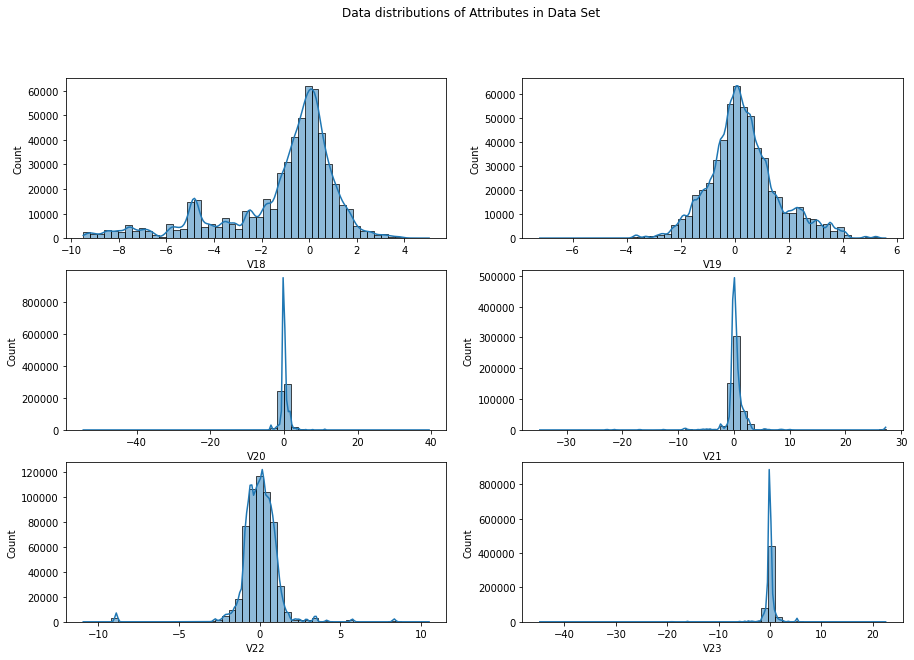

In [19]:
data_distribution(columns[18:24])

**Most of the graphs above show normal Gaussian Distribution except V18 which means no transformation is required for most of the columns**
1. V18 = Left Skewed

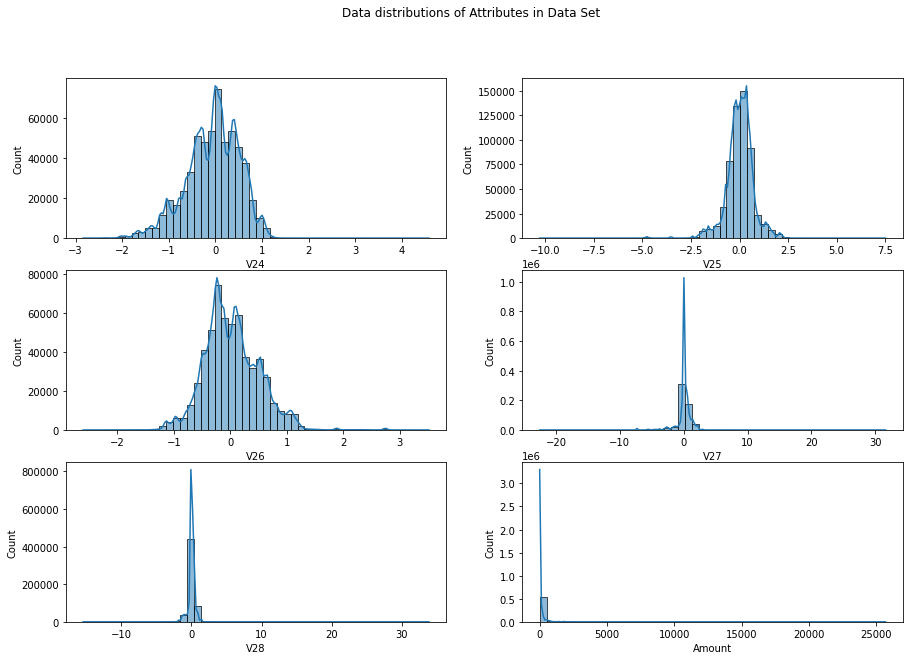

In [20]:
data_distribution(columns[24:30])

**In the graph above it is seen that the Amount variable has left skewness in the Amount data and it is seen that V24 has a Gaussian Distribution but doesn't show a smooth curve so we will have to transform the data.**
1. V24 = Not Smooth Gaussian

### Transforming the Data:

For transforming the data we will use the Power Transformer from sklearn. The variables to be transformed are:
1. Time
2. V1
3. V3
4. V4
5. V7
6. V10
7. V11
8. V12
9. V14
10. V16
11. V17
12. V18
13. V24

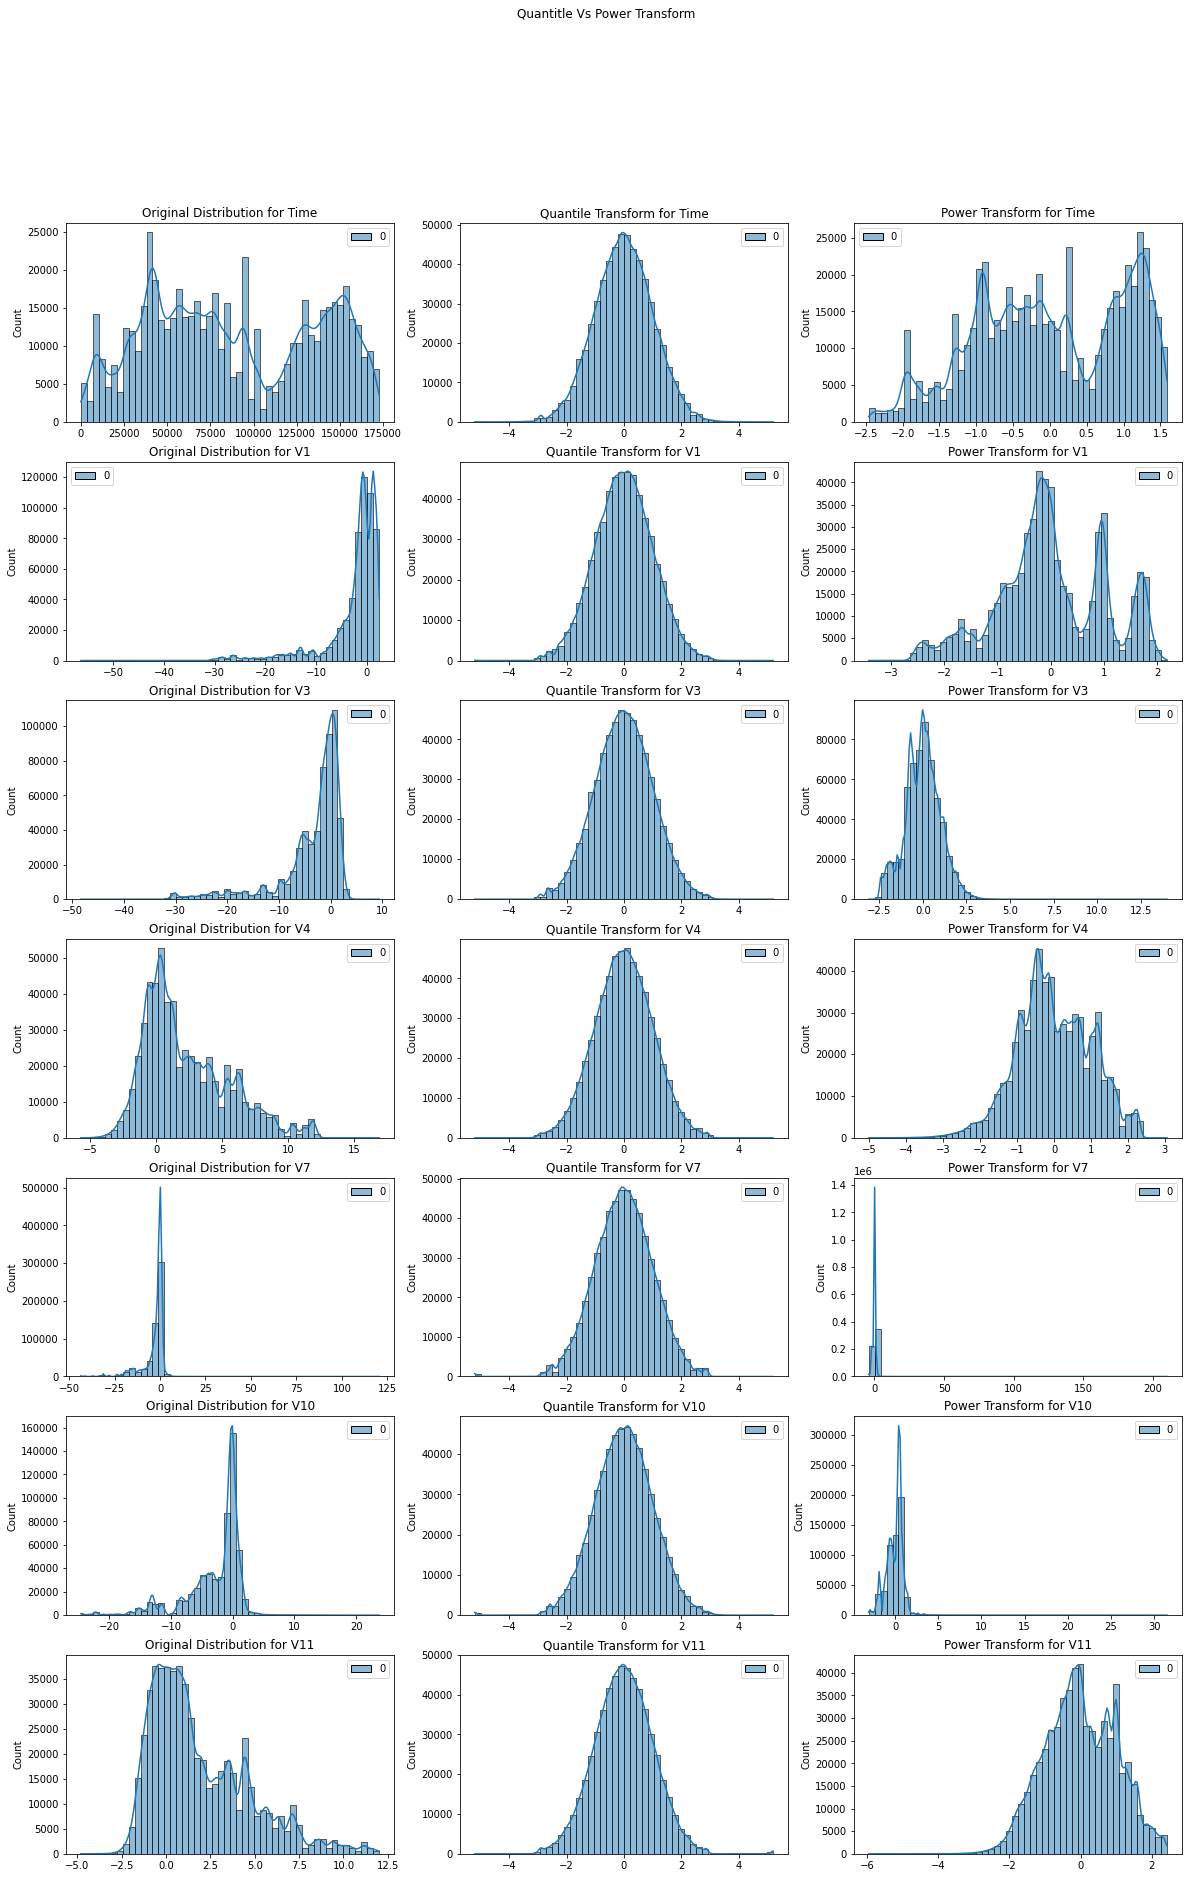

In [21]:
cols1 = ["Time", "V1", "V3", "V4", "V7", "V10", "V11"]
cols2 = ["V12", "V14", "V16", "V17", "V18", "V19", "V24"]

def check_best_transformer(columns):
    pt = PowerTransformer()
    qt = QuantileTransformer(n_quantiles=500, output_distribution='normal')
    fig = plt.figure(figsize=(20,30))
    plt.suptitle("Quantitle Vs Power Transform")
    j = 1
    for i in columns:
        array = np.array(df[i]).reshape(-1, 1)
        y = pt.fit_transform(array)
        x = qt.fit_transform(array)
        plt.subplot(7,3,j)
        sns.histplot(array, bins = 50, kde = True)
        plt.title(f"Original Distribution for {i}")
        plt.subplot(7,3,j+1)
        sns.histplot(x, bins = 50, kde = True)
        plt.title(f"Quantile Transform for {i}")
        plt.subplot(7,3,j+2)
        sns.histplot(y, bins = 50, kde = True)
        plt.title(f"Power Transform for {i}")
        j += 3

check_best_transformer(cols1)

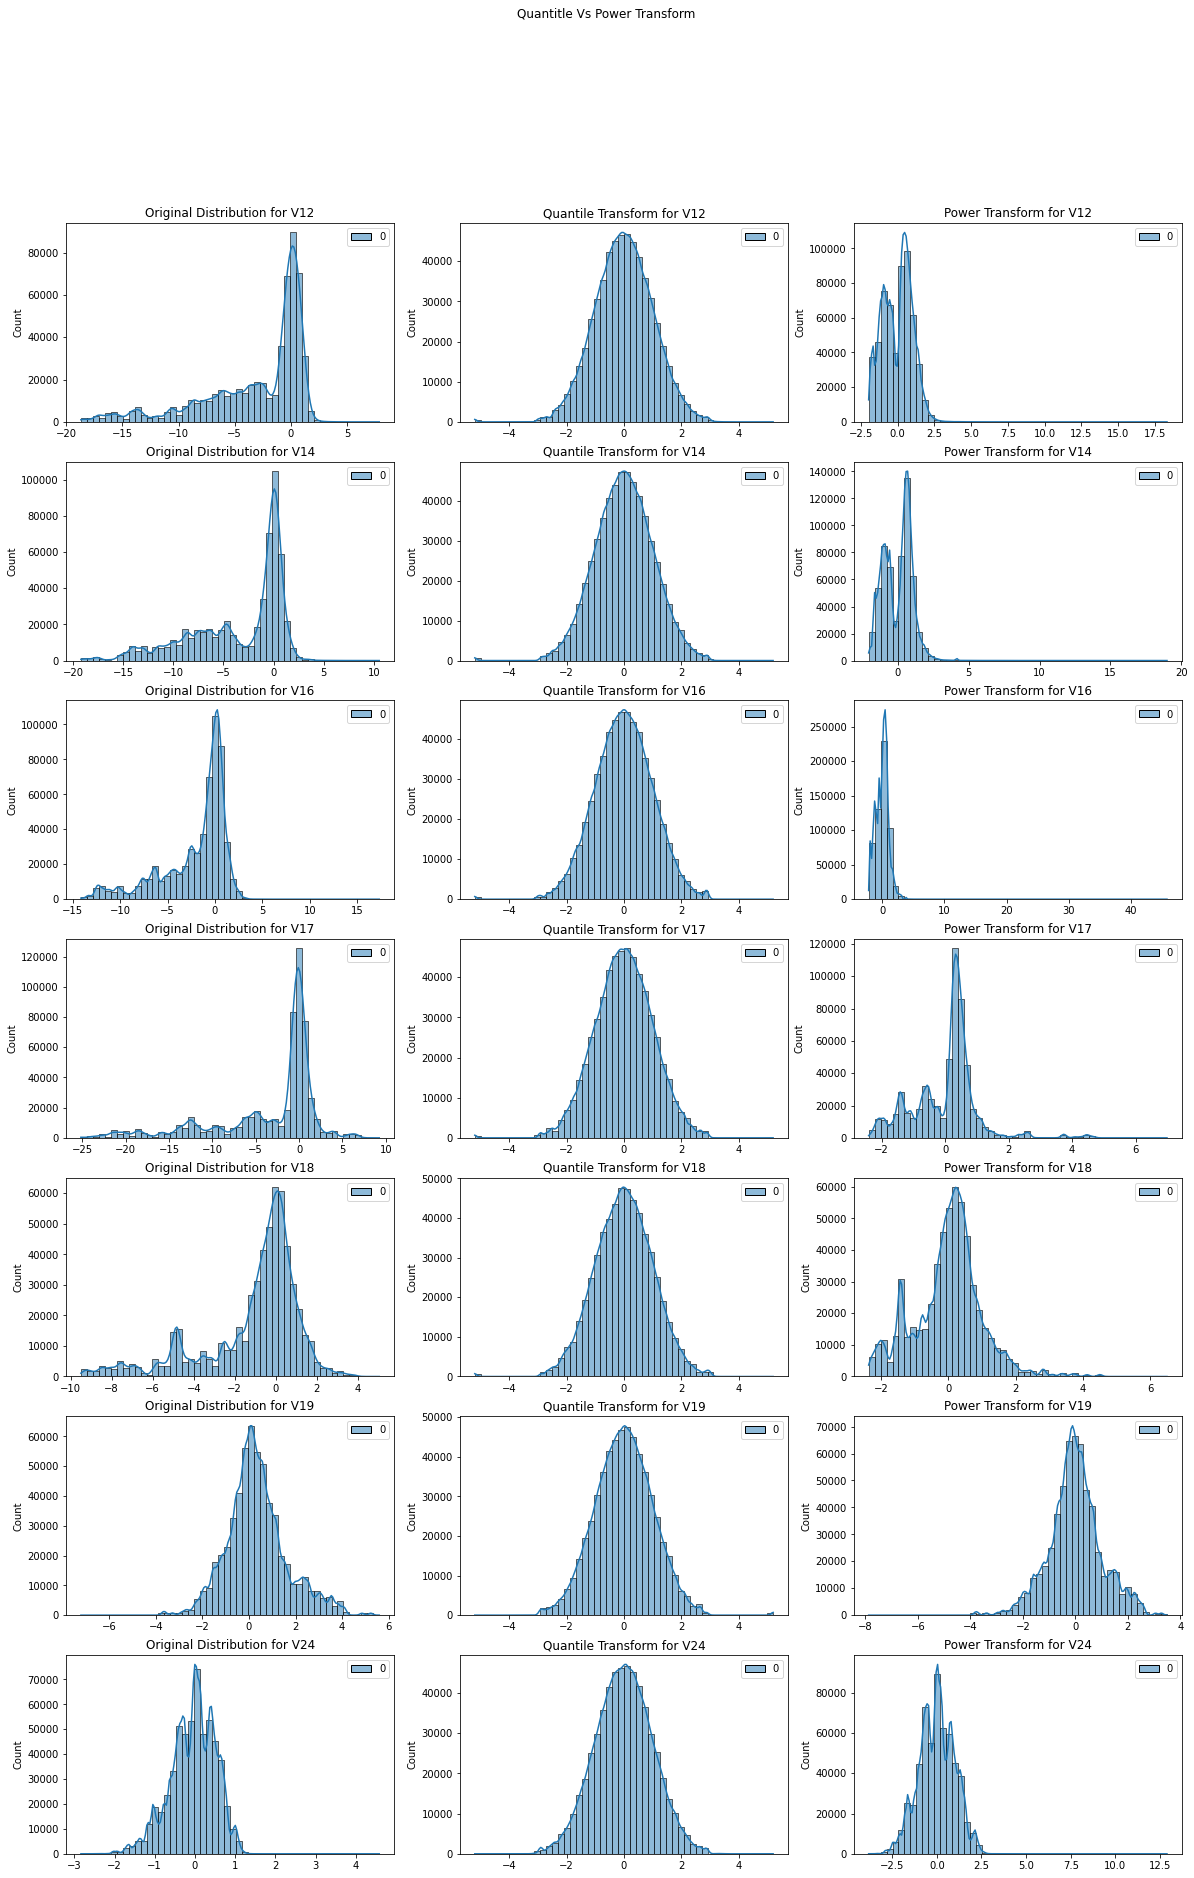

In [22]:
check_best_transformer(cols2)

**It is clearly seen from the graphs above that Quantile Transformer works a better job at transforming the data into Gaussian Distribution. So we will apply the Quantile Tranformer on our data.**

In [23]:
qt = QuantileTransformer(n_quantiles=500, output_distribution='normal')
cols = cols1 + cols2
for i in cols:
    df[i] = qt.fit_transform(np.array(df[i]).reshape(-1,1))
    print(f"{i} transformation Successful!")


Time transformation Successful!
V1 transformation Successful!
V3 transformation Successful!
V4 transformation Successful!
V7 transformation Successful!
V10 transformation Successful!
V11 transformation Successful!
V12 transformation Successful!
V14 transformation Successful!
V16 transformation Successful!
V17 transformation Successful!
V18 transformation Successful!
V19 transformation Successful!
V24 transformation Successful!


### Correlation Graph:

Now we will check the correlation between independent variables and the target variables. To do this we will use the Pearson Correlation. the Pearson Correalation Coefficient ranges from (-1 to 1) where -1 means that the data is negatively correlated, 1 means that the data is positively correlated and 0 means that there is no correlation between the variables.

[]

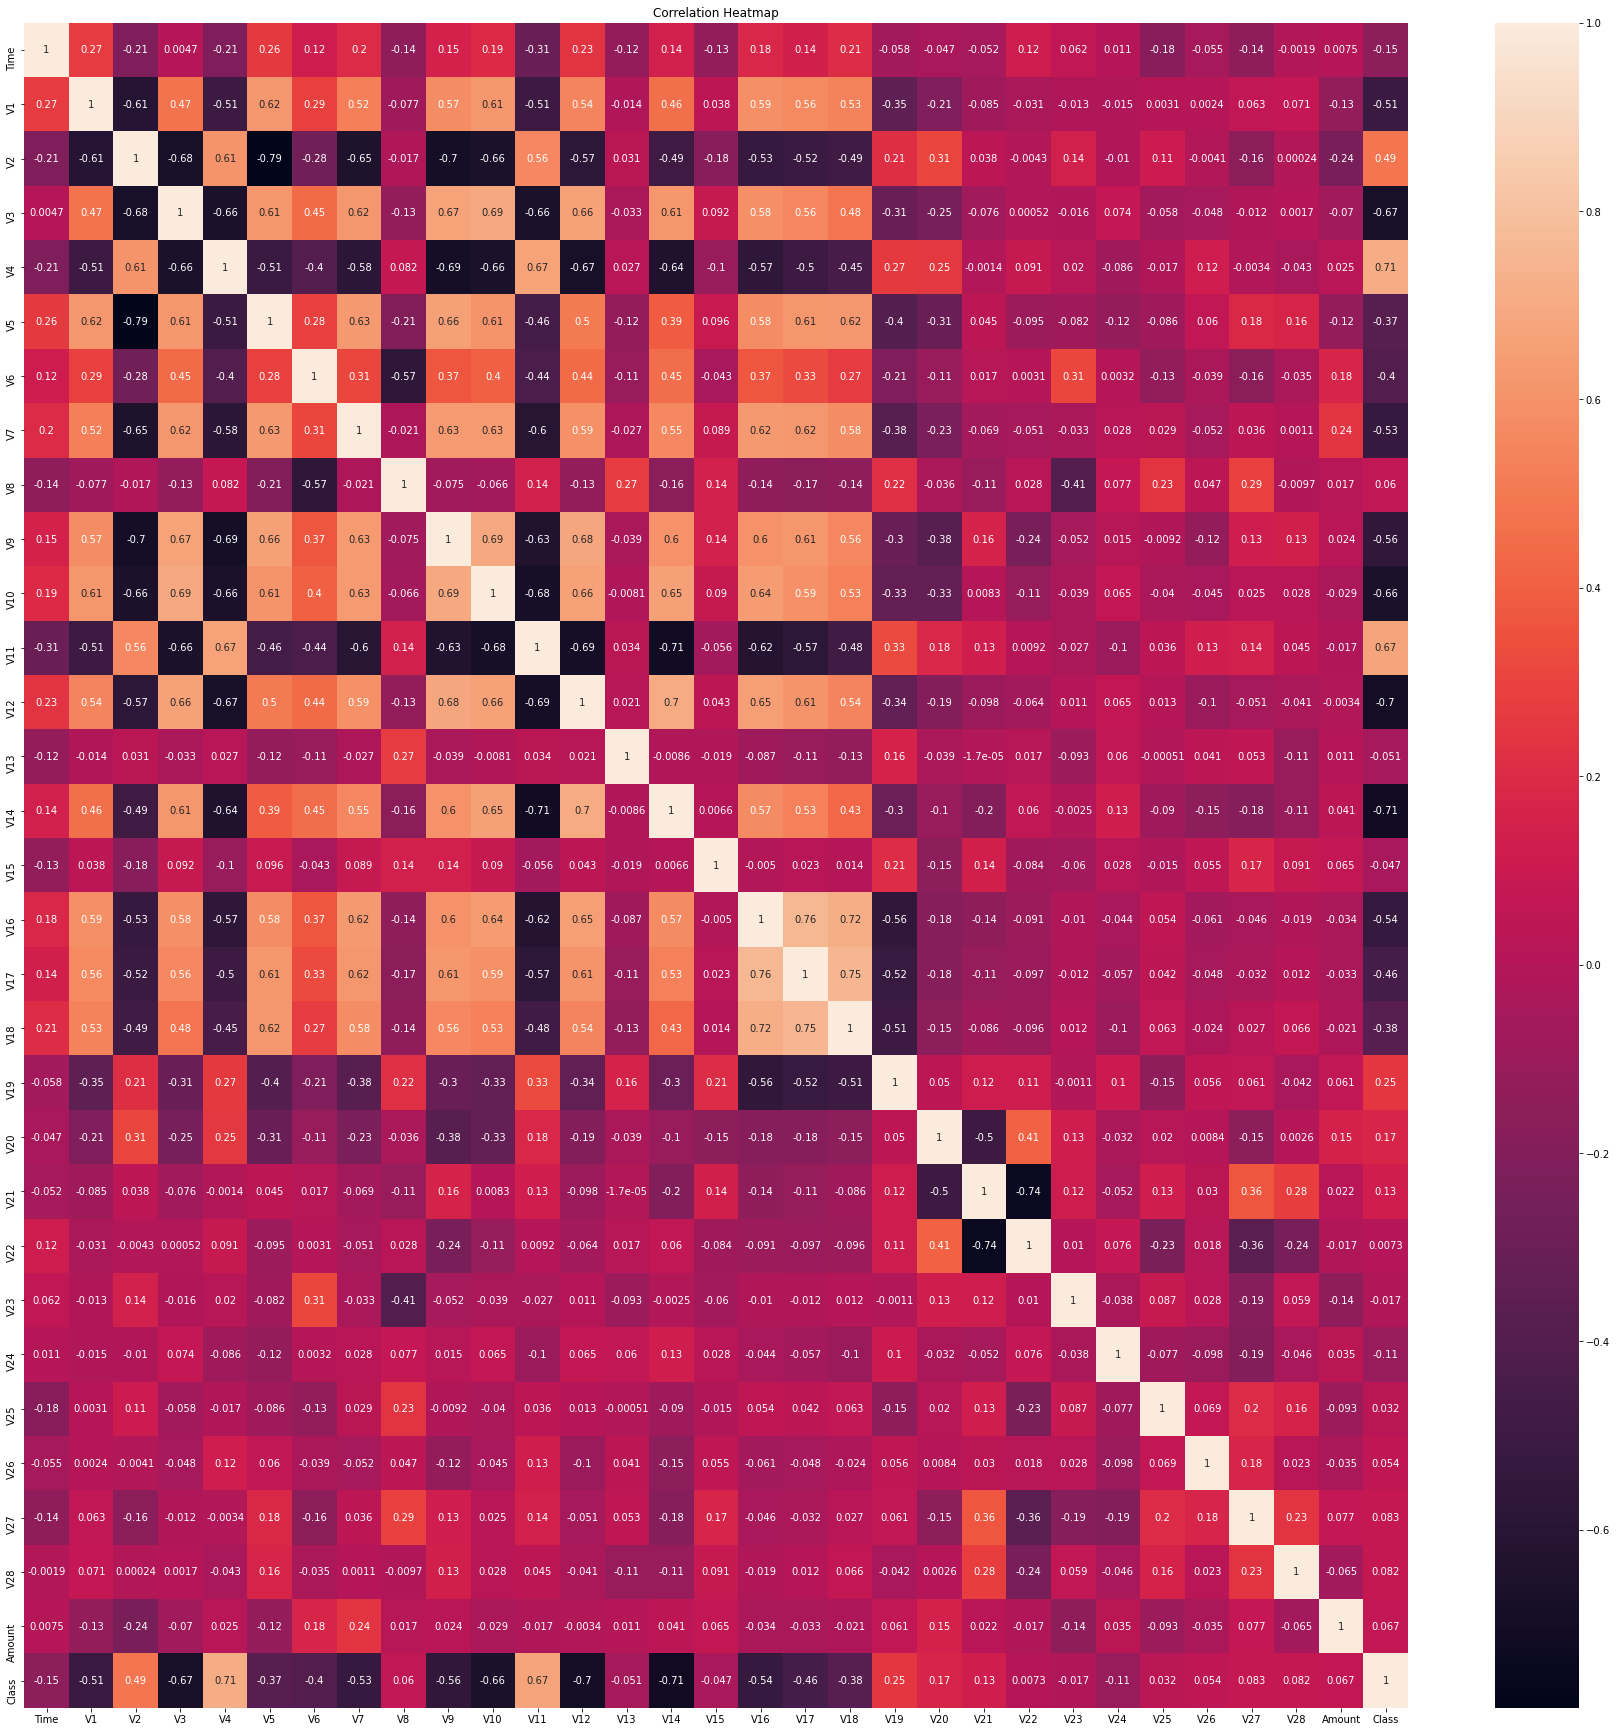

In [24]:
figure = plt.figure(figsize=(31, 31))
sns.heatmap(df.corr(), annot = True)
plt.title("Correlation Heatmap")
plt.plot()

**From the heatmap above we can see that there is a significant relation between some of the the independent variables so we might have to drop some columns from our dataset. We will keep the threshold at 0.7 and check for correlation between the columns.**

In [25]:
corr = df.corr()
pairs = []
for i in list(corr.columns)[:30]:
    for j in list(corr.columns)[:30]:
        if abs(corr.loc[i,j])>0.7 and corr.loc[i,j] != 1:
            pairs.append([i, j])
            if [i, j] not in pairs or [j, i] not in pairs:
                print(i, ' ',j ,' ', corr.loc[i,j])

V2   V5   -0.7889032761875934
V11   V14   -0.7075219745589922
V12   V14   0.702844816762175
V16   V17   0.7561543024441548
V16   V18   0.7162245399102984
V17   V18   0.749340624895049
V21   V22   -0.7445134224676848


From the above results we can observe that:
1. V2 and V5 show strong correlation so we will drop the V5 Column.
2. V12 and V11 are highly correlated with V14 and thus can will have quite similar effect on the target variable so we will drop th column V14.
3. V16 V17 and V18 show a significant correlation so in this case we will drop the V17 column.
4. V21 and V22 also show high correlation so we will drop the V22 column.

In [26]:
df.drop(columns=["V5", "V14", "V17", "V22"], inplace = True)
df.shape

(568630, 27)

### Scatter Plots:
We will plot a scatter plot to check if there are any visible clusters in our data which can indicate if we can apply clustering on our data set.

[]

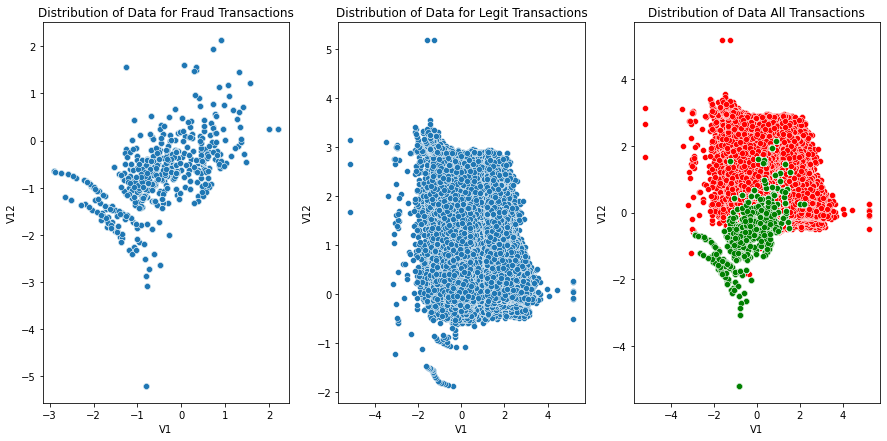

In [27]:
fig = plt.figure(figsize=(15,7))
#print(df[df["Class"]==1].shape)
plt.subplot(1,3,1)
sns.scatterplot(x = df[df["Class"]==1]["V1"], y = df[df["Class"]==1]["V12"])
plt.title("Distribution of Data for Fraud Transactions")
plt.plot()
plt.subplot(1,3,2)
sns.scatterplot(x = df[df["Class"]==0]["V1"], y = df[df["Class"]==0]["V12"])
plt.title("Distribution of Data for Legit Transactions")
plt.plot()
plt.subplot(1,3,3)
sns.scatterplot(x = df[df["Class"]==0]["V1"], y = df[df["Class"]==0]["V12"], color = "red")
sns.scatterplot(x = df[df["Class"]==1]["V1"], y = df[df["Class"]==1]["V12"], color ="green")
plt.title("Distribution of Data All Transactions")
plt.plot()

There are no visible clusters in our data. It is visible that both the transactions fraud and legit are overlapping and don't show any significant distinguishable clusters. 

In [28]:
X = df.iloc[:, :26].values
Y = df.iloc[:, 26].values

def classification_evaluation(classifier, X, Y, classifier_name, columns):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    accuracy_arr = np.zeros(shape=(1,10))
    f1_score_arr = np.zeros(shape=(1,10))
    precision_arr = np.zeros(shape=(1,10))
    recall_arr = np.zeros(shape=(1,10))
    feature_importance_arr = np.zeros(shape=(1,26))
    time_arr = []
    

    cv = StratifiedKFold(n_splits=10)
    fig, ax = plt.subplots(figsize=(15, 10))
    start_time = time.time()
    for i, (train, test) in enumerate(cv.split(X, Y)):
        itr_start_time = time.time()
        classifier.fit(X[train], Y[train])
        itr_end_time = time.time()
        viz = plot_roc_curve(classifier, X[test], Y[test],
                             name=f'ROC fold {i}',
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        
        try:
            feature_importance_arr += classifier.feature_importances_
        except:
            try:
                feature_importance_arr += np.array([abs(i) for i in classifier.coef_[0]])
            except:
                feature_importance_arr += np.array([abs(i) for i in permutation_importance(classifier, X[test], Y[test]).importances_mean])
            
        
        predict = classifier.predict(X[test])
        accuracy = classifier.score(X[test], Y[test])
        accuracy_arr[0, i] = accuracy
        f1 = f1_score(predict, Y[test])
        f1_score_arr[0, i] = f1
        precision = precision_score(predict, Y[test])
        precision_arr[0, i] = precision
        recall = recall_score(predict, Y[test])
        recall_arr[0, i] = recall
        train, test = train, test
        time_arr.append(itr_end_time-itr_start_time)
        print(f"Fold-{i}:  accuracy: {accuracy}  f1-score: {f1}  precision: {precision}  recall: {recall}  time: {itr_end_time-itr_start_time}")
    end_time = time.time()
    
    print()
    print(f"Classification Report for {classifier_name}")
    print("Average Accuracy :", np.mean(accuracy_arr))
    print("Average F1-Score :", np.mean(f1_score_arr))
    print("Average Precision :", np.mean(precision_arr))
    print("Average Recall :", np.mean(recall_arr))
    print("Total Time :", end_time - start_time)
    
    fig = plt.figure(figsize=(15, 10))
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title=f"Receiver Operating Characteristic for {classifier_name}")
    ax.legend(loc="lower right")
    plt.show()
    
    feature_importance_arr /= 10
    
    fig = plt.figure(figsize=(15, 10))
    
    plt.subplot(1, 2, 1)
    feature_imp = pd.Series(feature_importance_arr[0], index = columns[:26])
    feature_imp.nlargest(10).plot(kind = 'bar')
    plt.title(f"Feature Importance of {classifier_name}")
    
    
    plt.subplot(1,2,2)
    plt.plot(time_arr, 'go-', color="darkblue")
    plt.plot([max(time_arr) for i in range(10)], color='lightcoral', label='UL')
    plt.plot([min(time_arr) for i in range(10)], color='lightgreen', label='LL')
    plt.title("Training time for every iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Time in sec.")
    plt.legend(loc="upper right")
    
    plt.show()
    
    return np.mean(accuracy_arr), np.mean(f1_score_arr), np.mean(precision_arr), np.mean(recall_arr), mean_auc

In [29]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

In [38]:
def base_model():
    model = Sequential()
    model.add(Dense(24, input_dim=26, activation="relu"))
    model.add(Dense(12, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

classifier = KerasClassifier(build_fn=base_model, epochs=100, batch_size=5, verbose=0)
classifier.fit(X, Y)
print("Training Complete")

perm = PermutationImportance(classifier, random_state=1).fit(X,Y)
eli5.show_weights(perm, feature_names = df.columns.toList())